# Computer Exercise 3: Recursive Estimation and Models with Time-Varying Parameters

Time Series Analysis  
Lund University  
2025




This computer exercise treats recursive parameter estimation using Kalman filtering and recursive least squares. We attempt to model dynamic systems of both the SARIMA-type, having time-varying A and C polynomials, as well as to allow for ARMAX processes which have a synthetic input signal and time-varying B polynomial.

## Preparations before the lab

Read Chapter 8 in the course textbook as well as this guide to the computer exercise.

Answers to some of the computer exercise will be graded using the course's *Mozquizto* page, available at `https://quizms.maths.lth.se`. Ensure that you can access the system before the exercise and answer the preparatory questions as well as (at least) three of numbered exercise questions below *before the exercise*. These questions aim at allowing to check your implementation.

Before the computer exercise:

1. Express an AR(2) process on state space form and estimate the parameters of the process using a Kalman filter as specified in Sections 2.2 and 2.3.

2. Write a Python script that simulates the process $u_t$ in Section 2.4 below. Let $u_t$ be a Markov chain that switches slowly between two states, using $p_{11}=p_{22}=7/8$ and $p_{12}=p_{21}=1/8$.  
   Hint: This is easy to do using a loop where you at each time instance change state according to the specified probabilities.

Note that you are expected to be able to answer detailed questions on your implementation.

It should be stressed that a thorough understanding of the material in this exercise is important to be able to complete the course project, and we encourage you to discuss any questions you might have on the exercises with the teaching staff. This will save you a lot of time when you start working with the project!

You are allowed to solve the exercise in groups of two, but not more. Please respect this.

### Answers to preparations 

Note that the state space representation is not unique. Start with an $AR(2)$ process given by, 
$$
    y_t + a_1 y_{t-1} + a_2 y_{t-2} = e_t
$$
The aim is to find a state space representation on the form, 
$$
    \begin{aligned}
    \mathbf{x}_{t+1} &= A\mathbf{x}_t + B\mathbf{u}_t + \mathbf{e}_t \\
    \mathbf{y}_t &= C \mathbf{x}_t + \mathbf{w}_t
    \end{aligned}
$$
Let
$$
    \mathbf{x}_t = \begin{bmatrix} y_t \\ y_{t-1} \end{bmatrix}
$$
We reorganize the $AR(2)$ process, and add a second row for $y_{t-1}$
$$
    \begin{aligned}
    y_t &= - a_1 y_{t-1} - a_2 y_{t-1} +  e_t \\
    y_{t-1} &= y_{t-1}
    \end{aligned}
$$
Expressed on matrix form, this becomes, 
$$
    \mathbf{x}_t = \begin{bmatrix} -a_1 & -a_2 \\ 1 & 0 \end{bmatrix} \mathbf{x}_{t-1} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} e_t
$$
Then $y_t$ can be recovered from, 
$$
    y_t = \begin{bmatrix} 1 & 0 \end{bmatrix} \mathbf{x}_t
$$
This is the **controllable canonical form**. Alternatively, we could have used the **observable canonical form**
$$
    \begin{aligned}
    \mathbf{x}_t &= \begin{bmatrix} -a_1 & 1 \\ -a_2 & 0 \end{bmatrix} \mathbf{x}_{t-1} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} e_t \\
    y_t &= \begin{bmatrix} 1 & 0 \end{bmatrix} \mathbf{x}_t
    \end{aligned}
$$
For Markov chain, see code below 

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal


# Import tsa_lth library
import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')
from tsa_lth.modelling import recursiveAR, recursiveARMA, filter, estimateARMA, PEM, polydiv
from tsa_lth.analysis import plotACFnPACF
from tsa_lth.tests import whiteness_test, check_if_normal
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)



In [2]:
def simulate_markov(p, n, s0=None): 
    '''
    Simluates a simple two state markov process with the stated being represetned by 0 and 1
    Switches states symmetrically according to probability p to stay in the state and q to switch. 

    Args: 
        p (float): Probability to switch states, probability to not switch is hence 1 - p
        n (int):   Number of simulated states. 
        s0 (int):  Initial state 1 or 0, if not provided will be 50/50 randomized. 

    Returns: 
        numpy.ndarray: The simulated sequence of states with size (n,)
    '''
    if s0 is None: 
        s0 = np.random.randint(2)

    # Allocate a sequence 
    sequence = np.zeros(n, dtype=bool)
    sequence[0] = s0

    # Generate the sequence 
    for i in range(1, n):
        sequence[i] = sequence[i-1] != (np.random.rand() < p)
    
    return sequence


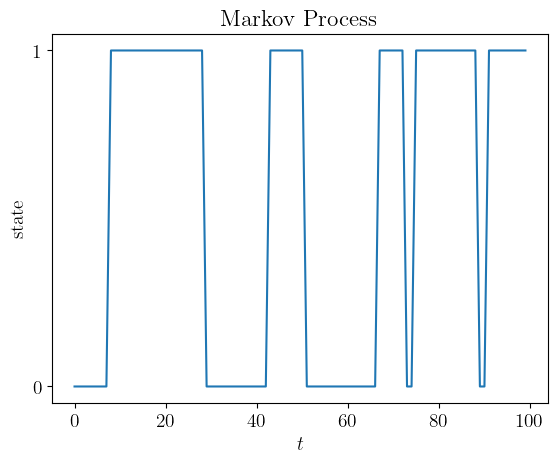

In [3]:
# Demonstration of markov function implementation 

seq = simulate_markov(1/8, 100)

fig, ax = plt.subplots()
ax.plot(seq)
ax.set_xlabel('$t$')
ax.set_ylabel('state')
ax.set_title('Markov Process')
ax.set_yticks([0, 1])

## 2.1 Recursive least squares estimation

Load the data material `tar2.dat`, the data is an AR(2)-process with one time dependent parameter and the other one constant. The correct parameter trajectories are stored in the file `thx.dat`. Use `subplot` to plot the data and the parameter in the same figure.

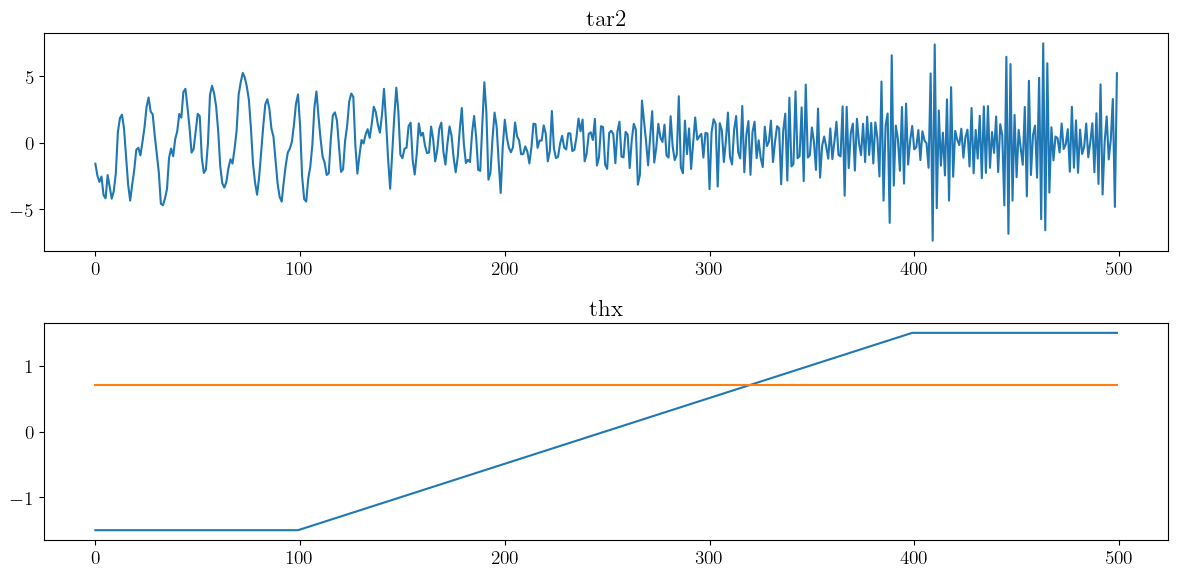

In [4]:
# Load data
tar2 = np.loadtxt('../data/tar2.dat')
thx = np.loadtxt('../data/thx.dat')

# Plot the data
plt.figure(1, figsize=(12, 6))
plt.subplot(211)
plt.plot(tar2)
plt.title('tar2')
plt.subplot(212)
plt.plot(thx)
plt.title('thx')
plt.tight_layout()
plt.show()

Use the Python `recursiveAR` to estimate the $A(z)$ polynomial recursively. Here, `Aest` is the estimated parameters, `yhat` is the estimate of $y_t$ based on the estimated $A(z)$ polynomial and past values of $y_t$. Try different forgetting factors, using ${\lambda}= 1,\, 0.95,\, 0.9$. Plot the parameter estimates together with the true parameter. What effect does the value of $\lambda$ have?

### recursiveAR() docstring 
Performs recursive estimation of autoregressive (AR) model parameters using the  
Recursive Least Squares method.  
  
Parameters:  
    - data (list/ndarray): Time series data.  
    - order (int): Order of the AR model.  
    - forgetting_factor (float, optional): Forgetting factor, defaults to 1.0.  
    - init_var (float, optional): Initial variance for covariance matrix, defaults to 1000.  
    - theta_guess (ndarray, optional): Initial guess for the AR parameters, defaults to None (zero initialization).  
      
Returns:  
    - tuple: Estimated AR parameters and predicted values vector.

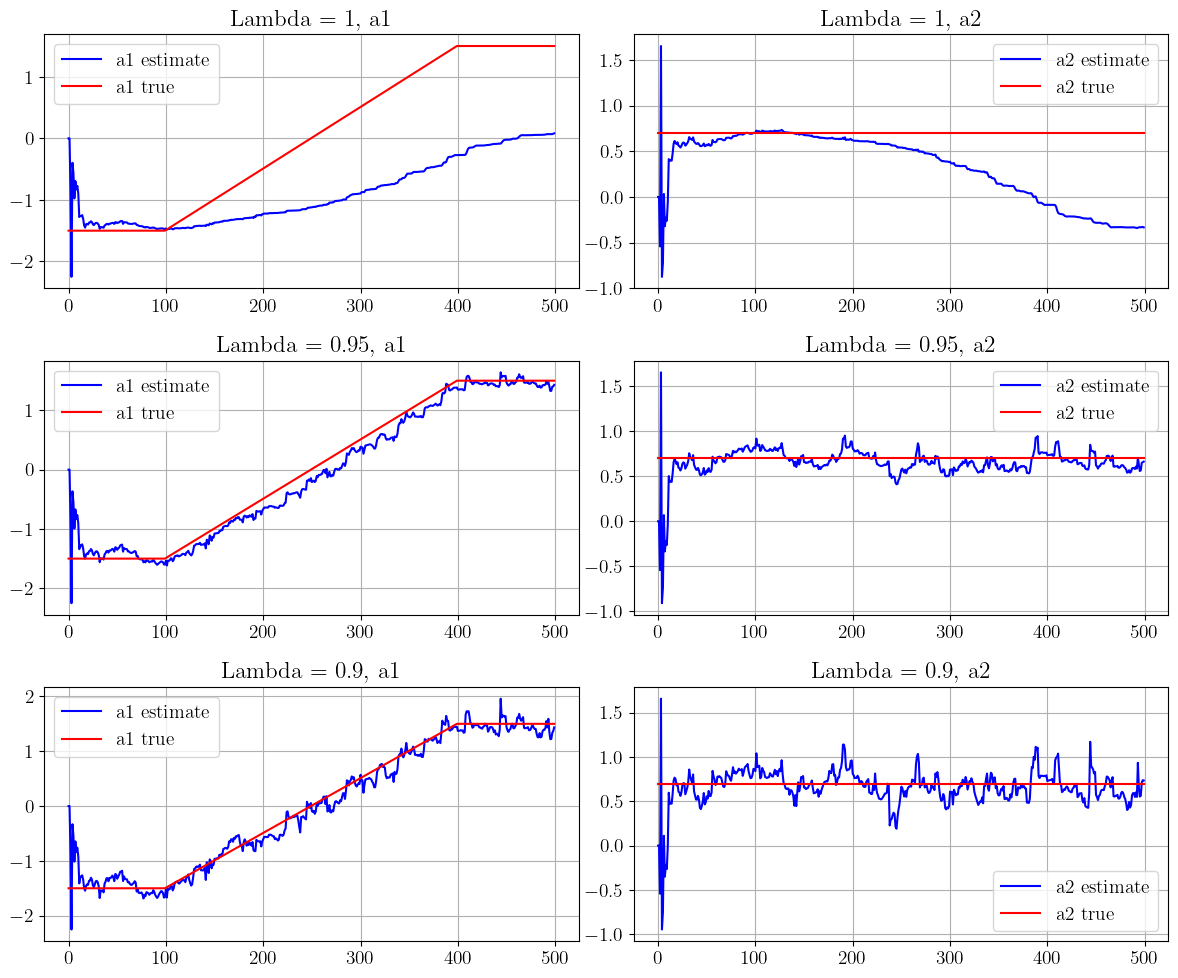

In [5]:
# Test different forgetting factors (lambdas)
lambdas = [1, 0.95, 0.9]

plt.figure(2, figsize=(12, 10))
for i, lam in enumerate(lambdas):
    # give it the data the model order, the forgetting factor and an initial guess for the parameters you can find the function in modeling.py
    Aest, yhat = recursiveAR(tar2, 2, forgetting_factor=lam, theta_guess=np.array([[0], [0]]))
    
    # Plot a1 parameter
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(Aest[:, 0], 'b', label='a1 estimate')
    plt.plot(thx[:, 0], 'r', label='a1 true')
    plt.title(f'Lambda = {lam}, a1')
    plt.legend()
    plt.grid(True)
    
    # Plot a2 parameter
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(Aest[:, 1], 'b', label='a2 estimate')
    plt.plot(thx[:, 1], 'r', label='a2 true')
    plt.title(f'Lambda = {lam}, a2')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

To choose $\lambda$, one option is to use the least squares estimate.

Min LS: 639.6315 ; lambda:0.9409


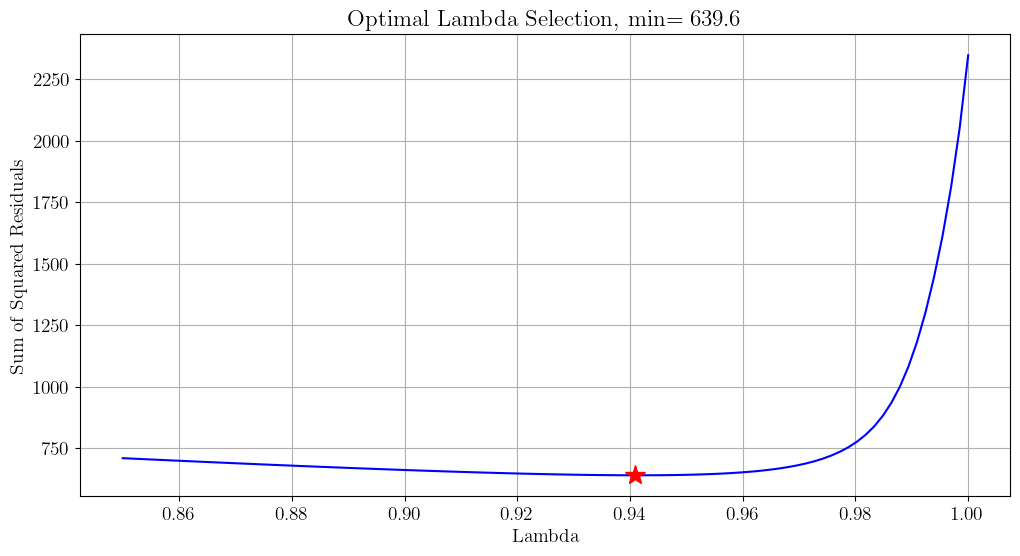

In [6]:
# Find optimal lambda
n = 100
lambda_line = np.linspace(0.85, 1, n)
ls2 = np.zeros(n)

for i in range(len(lambda_line)):
    Aest, yhat = recursiveAR(tar2, order=2, forgetting_factor=lambda_line[i], theta_guess=np.array([[0], [0]]))
    ls2[i] = np.sum((tar2 - yhat)**2)

# Find minimum
opt_ind = np.argmin(ls2)
lambda_opt = lambda_line[opt_ind]

print(f'Min LS: {ls2[opt_ind]:.4f} ; lambda:{lambda_opt:.4f}')

# Plot
plt.figure(3, figsize=(12, 6))
plt.plot(lambda_line, ls2, 'b-')
plt.plot(lambda_opt, ls2[opt_ind], 'r*', markersize=15)
plt.xlabel('Lambda')
plt.ylabel('Sum of Squared Residuals')
plt.title(f'Optimal Lambda Selection, min$={ls2[opt_ind]:.1f}$')
plt.grid(True)
plt.show()

**Question 1**  
In Mozquizto, answer question 1.

## 2.2 Kalman filtering of time series

A quite important drawback of the RLS estimate is that it should not be used to estimate MA parameters, making it unsuitable for, e.g., ARMA processes. We continue to again estimate the AR parameters from the previous section, but by using the Kalman filter. Note that the Kalman implementation can be extended to also allow for MA coefficients.

We here make use of the example code given in Section 3. At first, ignore the part of the example code for the 2-step prediction. This code uses data up to time $t-1$ to predict the state value $\hat{x}_{t|t-1}$, stored in the variable `x_t1`, and then use this value to predict (the one-step prediction) $\hat{y}_{t|t-1}$. The prediction error (also often termed the prediction residual) between $\hat{y}_{t|t-1}$ and $y_t$, i.e.,
$$
\epsilon_{t|t} = y_t - \hat{y}_{t|t-1}
$$
is then used to update the Kalman filter. Here, the prediction residual is stored in the variable `ehat`.

Proceed to complete the missing part of the code (ignore the part for the 2-step prediction). Use the tar2 data as $y_t$. Then, to be able to check your implementation, set
```python
Re    = np.array([[0.004, 0], [0, 0]])
Rw    = 1.25
Rx_t1 = 10 * np.eye(2)
```
Also, set the initial value of the state vector to zero values. This will set the covariance matrix of the observation (`Re`) and measurement (`Rw`) noises, as well as the initial state vector and its covariance matrix. The large initial value for `Rx_t1`, i.e., $R^{x,x}_{t+1|t}$, indicates that we have little confidence in the initial states.

Notice in particular that the way `Re` is selected reflects the assumption that the first parameter varies, whereas the second does not. Plot the resulting parameter estimates and notice the difference in convergence between the two parameters.

0.6928290379049066


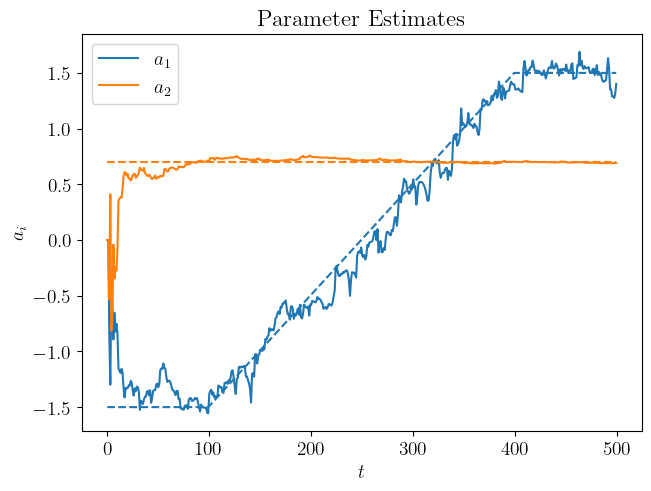

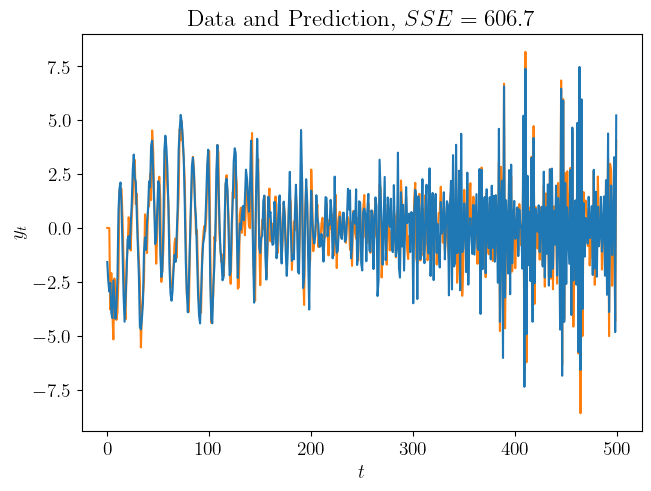

In [37]:
# Estimation of AR(2) using Kalman filter

# Data is given in tar2, the model is an AR(2), hence p = 2, q = 0
y = tar2
N = y.size
p = 2

# Define the state space equations. 
A   = np.eye(p)
Re  = np.array([[0.004, 0], [0, 0]])    # State covariance matrix
Rw  = 1.25                             # Observation variance

# Set some initial values
Rx_t1 = 10 * np.eye(p)      # R_{1|0}^{x,x}
h_et  = np.zeros(N)         # Estimated prediction error.
xt    = np.zeros((p, N))    # Estimated states. 
yhat = np.zeros(N)
yhat1 = np.zeros(N + 1)     # Estimated 1-step prediction.

# Since we are using an AR(2), we use 2 previous y values. We can start earliest at t = 2.
for t in range(2, N):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]                  # x_{t|t-1} 
    Ct = np.array([[-y[t - 1], -y[t - 2]]])  # C_{t|t-1}, Two previous y values due to AR(2) component. No h_et since no MA component. 
    
    # Update the parameter estimates.
    Ry = Ct @ Rx_t1 @ Ct.T + Rw            # R_{t|t-1}^{y,y}
    Kt = Rx_t1 @ Ct.T / Ry                 # K_t
    yhat[t] = (Ct @ x_t1)[0]               # \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat[t]               # Prediction error, get only element at 0 to avoid deprecated scalar conversion 
    xt[:, t] = x_t1 + Kt[:, 0] * h_et[t]   # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T      # R^{x,x}_{t|t}
    Rx_t1 = A @ Rx_t @ A.T + Re         # R^{x,x}_{t+1|t} 

## 
## I am unsure if the prediction error should be formed using yhat or yhat1
## The example implementation uses yhatm but will they not just be shifted? 
## A closer look at the formulas we see that the Ct and X_t1 in the next step
## Will be the same as calculated next iteration. So why is yhat1 in the code
## outline?? 
##
## The upside I can think of, is if we save a vector of length N + 1, then 
## we can also predict the case after the lase time step. We can of course 
## no use it to calculate the squared errors. 
##
## UPDATE: This is true, the values in yhat and yhat1 will be the same. 
## Here we are looking at prediction errors, hence yhat is more natural  
##

# Squared prediction residuals 
sse = np.sum((yhat[2:] - y[2:]) ** 2)

# Plot the results 
fig, ax = plt.subplots(layout='constrained') 
col = ['C0', 'C1']
for i, a in enumerate(xt):
    ax.plot(a, color=col[i], label=(f'$a_{i+1}$'))
    ax.plot(thx[:, i], '--', color=col[i], label="")
ax.set_ylabel('$a_i$')
ax.set_xlabel('$t$')
ax.legend()
ax.set_title("Parameter Estimates")

fig, ax = plt.subplots(layout='constrained')
ax.plot(yhat, color='C1', label="True")
ax.plot(y, color='C0', label="Prediction")
ax.set_xlabel('$t$')
ax.set_ylabel('$y_t$')
ax.set_title(f"Data and Prediction, $SSE = {sse:.1f}$")

print(xt[1,-1])

**Question 2**

In Mozquizto, answer question 2.

This question strives to check that your implementation is correct. As you will use this as the basis for the following steps, as well as in the project, it is important that you get this to work properly. Ask the teaching staff to help you if you do not get the correct answer!

**Question 3**

In Mozquizto, answer question 3.

What effect has the choice of `Rw` and `Re` for the parameter estimates? Did you manage to improve the estimation by using Kalman filtering instead of RLS? Can you reduce the sum of the squared residual (`ehat`) by tuning `Re` and `Rw`?

## Answers to question 3

$\mathbf{R}_w$ is the covariance matrix for the measurement noise and $\mathbf{R}_e$ for the observation noises.  
As we have only one measurement, $\mathbf{R}_w$ is here a scalar, while $\mathbf{R}_e$ is a matrix. Larger values  
in $\mathbf{R}_e$ indicate we expect more variability in that parameter, here $a_1$, allowing it to converge towards  
new values faster, however it will also have larger variance around the true value. Larger values in $\mathbf{R}_w$  
on the other hand means we expect more variability in our measurements of the data, meaning each value is less certain.  
Hence, larger values mean slower convergence as each sample has less weight due to the larger variance. The default  
values beat the optimal recursive least squares and only very slight improvements were obtained by tweaking the parameters.  
The best do far is about 613. 

## 2.3 Using the Kalman filter for prediction

We now proceed to form a 2-step prediction using the Kalman filter. To do this, you need to complete the latter part of the example code. As it can be difficult to verify that the implementation is correct, we will use simulated data for this. To be able to check your implementation, use
```python
np.random.seed(0)
N  = 10000
ee = 0.1 * np.random.randn(N)
A0 = np.array([1, -0.8, 0.2])
y  = signal.lfilter([1], A0, ee)
Re = np.array([[1e-6, 0], [0, 1e-6]])
Rw = 0.1
```
We here select `Re` small to ensure that we get states that converge close to the true values (which is also why we select $N$ so large).

In order to form $\hat{y}_{t+2|t}$, you first need to form $\hat{C}_{t+2|t}$, as
$$
\hat{y}_{t+2|t} = \hat{C}_{t+2|t} \hat{x}_{t+2|t} = \hat{C}_{t+2|t} \hat{x}_{t|t}
$$
Note that, in general, $\hat{x}_{t+2|t} \neq \hat{x}_{t|t}$. Why does this equality hold here?

Proceed to write down an expression for $\hat{C}_{t+2|t}$ and note that this will depend on $\hat{y}_{t+1|t}$. As a result, you will first need to estimate $\hat{y}_{t+1|t}$, then use this value to form $\hat{C}_{t+2|t}$, and then finally use this to form $\hat{y}_{t+2|t}$. Update the example code with the missing lines.

To examine the predictions when the filter has converged, use the following code to plot the last 100 samples of $y_t$, $\hat{y}_{t|t-1}$, and $\hat{y}_{t+2|t}$.
```python
indV = range(N-102, N-1)
plt.plot(indV, [y[indV], yhat1[indV], yhat2[indV]])
plt.legend(['y_t', 'y_{t|t-1}', 'y_{t+2|t}'])
plt.title('Data vs predictions')
plt.xlabel('Time')
plt.xlim([indV[0], indV[-1]])
```
Notice that the plot stops at $N-2$. Why is that?

Plot the estimated states and check that they converge properly.

Sum of square errors, 1-step: 0.942, 2-step: 1.566


Text(0.5, 0, '$t$')

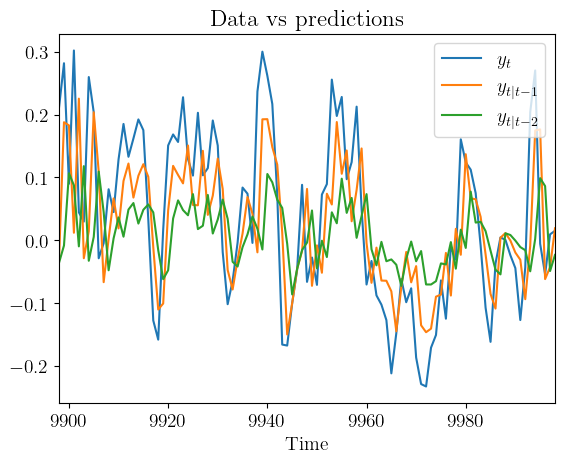

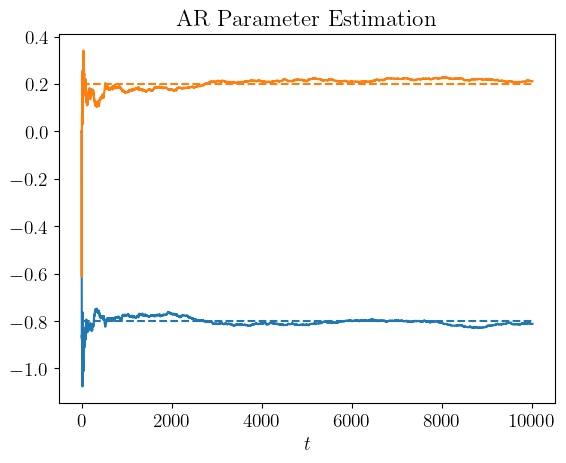

In [8]:
# Simulate data
np.random.seed(0)
N  = 10000
ee = 0.1 * np.random.randn(N)
A0 = np.array([1, -0.8, 0.2])

y  = signal.lfilter([1], A0, ee)

# Define covariance for the Kalman filter 
Re = np.array([[1e-6, 0], [0, 1e-6]])
Rw = 0.1
p = 2 

# Set some initial values
Rx_t1 = 10 * np.eye(p)      # R_{1|0}^{x,x}
h_et  = np.zeros(N)         # Estimated prediction error.
xt    = np.zeros((p, N))    # Estimated states. 
yhat1 = np.zeros(N+1)     # Estimated 1-step prediction.
yhat2 = np.zeros(N+2)     # Estimated 2-step prediction. 
 
# Since we are using an AR(2), we use 2 previous y values. We can start earliest at t = 2.
# Similarly, since we are interested in comaparing the predictions to known data, it makes
# Sense to only predict until N - 2
for t in range(2, N):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]                    # x_{t|t-1} 
    Ct = np.array([[-y[t - 1], -y[t - 2]]])  # C_{t|t-1}, Two previous y values due to AR(2) component. No h_et since no MA component. 
    
    # Update the parameter estimates.
    Ry = Ct @ Rx_t1 @ Ct.T + Rw            # R_{t|t-1}^{y,y}
    Kt = Rx_t1 @ Ct.T / Ry                 # K_t
    yhat = (Ct @ x_t1)[0]                  # \hat{y}_{t|t-1}
    h_et[t] = y[t] - yhat                  # Prediction error, get only element at 0 to avoid deprecated scalar conversion 
    xt[:, t] = x_t1 + Kt[:, 0] * h_et[t]   # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T      # R^{x,x}_{t|t}
    Rx_t1 = A @ Rx_t @ A.T + Re         # R^{x,x}_{t+1|t} 

    # Form \hat{y}_{t+1|t}.
    Ct1 = np.array([[-y[t], -y[t-1]]])    # C_{t+1|t}
    yhat1[t+1] = (Ct1 @ xt[:, t])[0]      # \hat{y}_{t+1|t} 

    # Form \hat{y}_{t+2|t}.
    Ct2 = np.array([[-yhat1[t+1], -y[t]]])   # C_{t+2|t}, same here 
    yhat2[t+2] = (Ct2 @ xt[:, t])[0]         # \hat{y}_{t+2|t}

# Remove predictions for which we do not have a comparison 
yhat1 = yhat1[:-1]
yhat2 = yhat2[:-2]

# Print the sum of square errors for the last 100 samples 
SSE1 = np.sum((yhat1[-100:] - y[-100:]) ** 2)
SSE2 = np.sum((yhat2[-100:] - y[-100:]) ** 2)

print(f"Sum of square errors, 1-step: {SSE1:.3f}, 2-step: {SSE2:.3f}") 

# Given plot to present 
indV = range(N-102, N-1)
fig, ax = plt.subplots()
ax.plot(indV, np.transpose([y[indV], yhat1[indV], yhat2[indV]]))
ax.legend(['$y_t$', '$y_{t|t-1}$', '$y_{t|t-2}$'])
ax.set_title('Data vs predictions')
ax.set_xlabel('Time')
ax.set_xlim([indV[0], indV[-1]])

# Plot the estimated parameters... 
parx = [0, N]
para1 = [A0[1], A0[1]]
para2 = [A0[2], A0[2]]

fig, ax = plt.subplots()
ax.plot(xt[0, :], color='C0', label='$a_1$')
ax.plot(parx, para1, '--', color='C0')
ax.plot(xt[1, :], color='C1', label='$a_2$')
ax.plot(parx, para2, '--', color='C1')
ax.set_title('AR Parameter Estimation')
ax.set_xlabel('$t$')



**Question 4**

In Mozquizto, answer question 4.

Again, it is important as you get your code to work properly as you will use this code in the project. Ask the teaching staff if you have problems!


## Answers to questions

$\hat{\mathbf{x}}_{t+2|t} = \hat{\mathbf{x}}_{t|t}$, since the best guess of the new $\hat{\mathbf{x}}$, i.e. the $a_i$ parameters, is that they remain unchanged.  
We see that since the update matrix from the state model is identity, $A = I$. The contribution to the  
update for $\hat{\mathbf{x}}_t$ is hence, $K_t (y_t - \hat{y}_t)$. Since $E[y_t - \hat{y}_t] = 0$, it follows that 
$E[\hat{\mathbf{x}}_{t+k|t}] = \hat{\mathbf{x}}_{t|t}\;\forall k$.  

The plot stops at N-2 because it is the last step for which we can make a 2 step prediction and still have data  
to compare with. We could of course still make a predicion for steps 10 001 and 10 002.


### Discussion
Compute the sum of the squared prediction residual for the last 100 samples (why not all?). Can you improve the estimate, i.e., lower the sum of the squared prediction residual by tuning the choice of `Rw` and `Re`?

Show the plot of $y_t$, $\hat{y}_{t|t-1}$, and $\hat{y}_{t+2|t}$, as well of the predicted states, to the teaching staff. Why is it that, in general, $\hat{x}_{t+2|t} \neq \hat{x}_{t|t}$?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

### Answers 

See below for code and images. The errors for the initial values were: 
1-step: 0.942
2-step: 1.566  

According to the logic we discussed previously, we could reduce the $R_e$ values even further,  
Then we should get even lower variability in the $\hat{a}_i$ estimates. Similarly, a larger value  
for $R_w$ would reduce rate at which $\hat{a}_i$ is updated. Does this lead to lower errors in the  
last 100 samples, once we have reached a steady state?  

I experimented, however I could not significantly increase the SSE. It is possible to ruin them however.  
The best improvement was -0.001 and -0.004.  

in general we should get the expected value for $\hat{\mathbf{x}}_{t+2|t}$ by applying the $A$ matrix  
twice. It is not in general identity. 

Sum of square errors, 1-step: 0.941, 2-step: 1.565


Text(0.5, 0, '$t$')

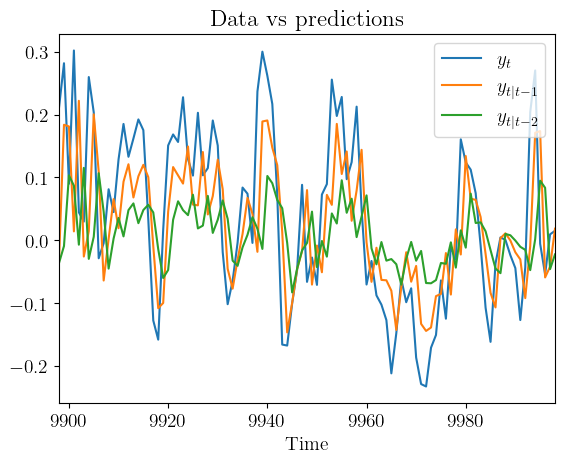

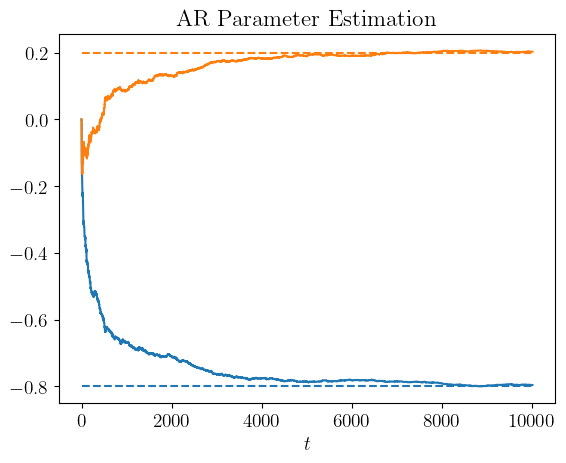

In [9]:

# Define covariance for the Kalman filter 
Re = np.array([[1e-10, 0], [0, 1e-10]])
Rw = 15
p = 2 

# Set some initial values
Rx_t1 = 10 * np.eye(p)      # R_{1|0}^{x,x}
h_et  = np.zeros(N)         # Estimated prediction error.
xt    = np.zeros((p, N))    # Estimated states. 
yhat1 = np.zeros(N+1)     # Estimated 1-step prediction.
yhat2 = np.zeros(N+2)     # Estimated 2-step prediction. 
 
# Since we are using an AR(2), we use 2 previous y values. We can start earliest at t = 2.
# Similarly, since we are interested in comaparing the predictions to known data, it makes
# Sense to only predict until N - 2
for t in range(2, N):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]                    # x_{t|t-1} 
    Ct = np.array([[-y[t - 1], -y[t - 2]]])  # C_{t|t-1}, Two previous y values due to AR(2) component. No h_et since no MA component. 
    
    # Update the parameter estimates.
    Ry = Ct @ Rx_t1 @ Ct.T + Rw            # R_{t|t-1}^{y,y}
    Kt = Rx_t1 @ Ct.T / Ry                 # K_t
    yhat = (Ct @ x_t1)[0]                  # \hat{y}_{t|t-1}
    h_et[t] = y[t] - yhat                  # Prediction error, get only element at 0 to avoid deprecated scalar conversion 
    xt[:, t] = x_t1 + Kt[:, 0] * h_et[t]   # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T      # R^{x,x}_{t|t}
    Rx_t1 = A @ Rx_t @ A.T + Re         # R^{x,x}_{t+1|t} 

    # Form \hat{y}_{t+1|t}.
    Ct1 = np.array([[-y[t], -y[t - 1]]])    # C_{t+1|t}
    yhat1[t+1] = (Ct1 @ xt[:, t])[0]        # \hat{y}_{t+1|t} 

    # Form \hat{y}_{t+2|t}.
    Ct2 = np.array([[-yhat1[t + 1], -y[t]]])   # C_{t+2|t}, same here 
    yhat2[t+2] = (Ct2 @ xt[:, t])[0]           # \hat{y}_{t+2|t}

# Remove predictions for which we do not have a comparison 
yhat1 = yhat1[:-1]
yhat2 = yhat2[:-2]

# Print the sum of square errors for the last 100 samples 
SSE1 = np.sum((yhat1[-100:] - y[-100:]) ** 2)
SSE2 = np.sum((yhat2[-100:] - y[-100:]) ** 2)

print(f"Sum of square errors, 1-step: {SSE1:.3f}, 2-step: {SSE2:.3f}") 

# Given plot to present 
indV = range(N-102, N-1)
fig, ax = plt.subplots()
ax.plot(indV, np.transpose([y[indV], yhat1[indV], yhat2[indV]]))
ax.legend(['$y_t$', '$y_{t|t-1}$', '$y_{t|t-2}$'])
ax.set_title('Data vs predictions')
ax.set_xlabel('Time')
ax.set_xlim([indV[0], indV[-1]])

# Plot the estimated parameters... 
parx = [0, N]
para1 = [A0[1], A0[1]]
para2 = [A0[2], A0[2]]

fig, ax = plt.subplots()
ax.plot(xt[0, :], color='C0', label='$a_1$')
ax.plot(parx, para1, '--', color='C0')
ax.plot(xt[1, :], color='C1', label='$a_2$')
ax.plot(parx, para2, '--', color='C1')
ax.set_title('AR Parameter Estimation')
ax.set_xlabel('$t$')

It is worth noting that in case you are using the Kalman filter to predict an MA or an ARMA process, your `C` vector will contain earlier noise values, i.e., $e_t$, $e_{t-1}$, etc. These noise values are obviously not known, so one then use the corresponding one-step prediction errors in place of these, i.e., $\epsilon_{t|t}$, $\epsilon_{t-1|t-1}$, etc. These values are here stored in the variable `ehat`.

*Important:* Note that when using the Kalman filter for prediction, you *should not* use the polynomial division techniques discussed in the earlier computer exercise, as presented in Chapter 6 in the course textbook. This will not yield the correct estimates! Instead, predictions needs to be made by updating the states as indicated in Chapter 8.

## 2.4 Quality control of a process

In the quality control division at a factory, one has found that the process which is to be followed shows a drift like
$$
x_t = x_{t-1} + e_t .
$$
However, it is not possible to measure the quality variable $x_t$ exactly, and one instead is limited to the observations
$$
y_t = x_t + bu_t + v_t ,
$$
where the processes $e_t$ and $v_t$ are two mutually uncorrelated sequences of white noise, with the variances $\sigma_e^2$ and $\sigma_v^2$. Furthermore, $b$ is a parameter. For simplicity, we assume that the external signal $u_t$ is known.

Use the script written in the preparatory exercise for the computer exercise to simulate the process with the input signal $u_t$. Select $b=20$, $\sigma_e^2 = 1$ and $\sigma_v^2 = 4$, but feel free to change these at will. Now consider $x_t$ and $b$ to be unknown, and use the Kalman filter you prepared and implement a filter that estimates $b$. Plot your estimates of the hidden states together with the true values. Plot the one-step prediction $\hat{y}_{t|t-1}$ as compared to the measured signal $y_t$.

Sum of square errors, 1-step: 5126.521


Text(0.5, 1.0, 'Estimated $x_t$')

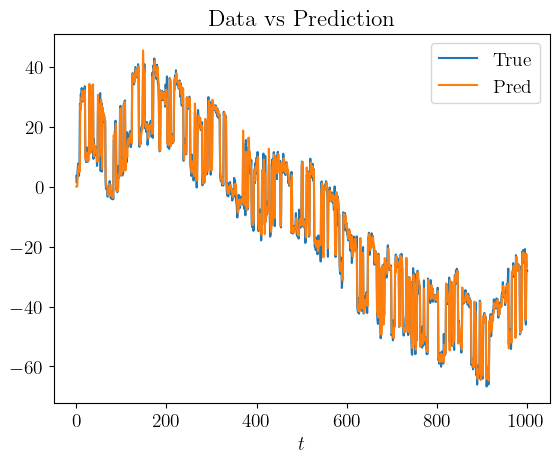

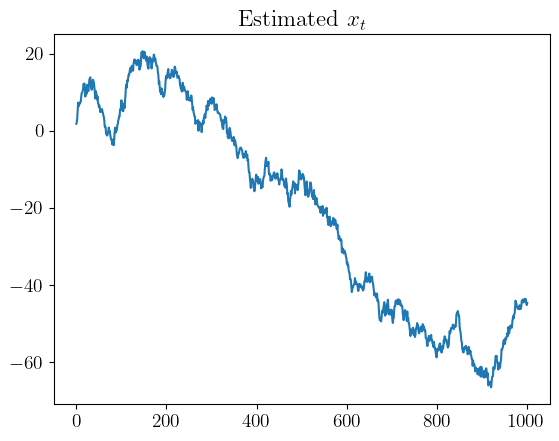

In [10]:
# Simulate data
np.random.seed(0)
N  = 1000
ee = np.random.randn(N + 1)
ev = 2 * np.random.randn(N + 1)
A0 = np.array([1, -1])

x = signal.lfilter([1], A0, ee)
u = simulate_markov(1/8, N + 1)
y = x + 20 * u + ev

# Define covariance for the Kalman filter 
Re = np.array([[1e-1, 0], [0, 1e-1]])
Rw = 0.1

A = np.eye(2)

# Set some initial values
Rx_t1 = 10 * np.eye(2)      # R_{1|0}^{x,x}
h_et  = np.zeros(N)         # Estimated prediction error.
xt    = np.zeros((p, N))    # Estimated states. 
yhat1 = np.zeros(N + 1)     # Estimated 1-step prediction.
 
# Since we are using an AR(2), we use 2 previous y values. We can start earliest at t = 2.
# Similarly, since we are interested in comaparing the predictions to known data, it makes
# Sense to only predict until N - 2
for t in range(2, N):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]                    # x_{t|t-1} 
    Ct = np.array([[1, u[t]]])  # C_{t|t-1}, Two previous y values due to AR(2) component. No h_et since no MA component. 
    
    # Update the parameter estimates.
    Ry = Ct @ Rx_t1 @ Ct.T + Rw            # R_{t|t-1}^{y,y}
    Kt = Rx_t1 @ Ct.T / Ry                 # K_t
    yhat = (Ct @ x_t1)[0]                  # \hat{y}_{t|t-1}
    h_et[t] = y[t] - yhat                  # Prediction error, get only element at 0 to avoid deprecated scalar conversion 
    xt[:, t] = x_t1 + Kt[:, 0] * h_et[t]   # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T      # R^{x,x}_{t|t}
    Rx_t1 = A @ Rx_t @ A.T + Re         # R^{x,x}_{t+1|t} 

    # Form \hat{y}_{t+1|t}.
    Ct1 = np.array([[1, u[t + 1]]])        # C_{t+1|t}
    yhat1[t+1] = (Ct1 @ xt[:, t])[0]      # \hat{y}_{t+1|t} 

# Remove predictions for which we do not have a comparison 
yhat1 = yhat1[:-1]

# Print the sum of square errors for the last 100 samples 
SSE1 = np.sum((yhat1[-100:] - y[-100:]) ** 2)

print(f"Sum of square errors, 1-step: {SSE1:.3f}") 

# Given plot to present 
fig, ax = plt.subplots()
ax.plot(y, label='True')
ax.plot(yhat1, label='Pred')
ax.legend()
ax.set_title('Data vs Prediction')
ax.set_xlabel('$t$')

fig, ax = plt.subplots()
ax.plot(x)
ax.set_title('Estimated $x_t$')


### Discussion
How should the state space vector be chosen? How would you choose an initial value of `Re` and `Rw`? How can then proceed to fine-tune the filter?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

### Answers  
We choose the state space vector to contain out unkowns. Then we simple have to express the entire problem  
on state space form. A question is, what would we do if we only had $u_t$ up to $t$? If it is completely unknown  
then there would not be any difference to $x_t$, we could put it in the state vector. But if it was "partially"  
unknown. Would it depend on the assumptions on how $u_t$ behaves?  

Is there a better way to tune $R_e$ and $R_w$ than choosing then depending on how you estimate the  
state vector will behave, i.e. $R_e$ higher if we expect them to change much and $R_w$ higher if we expect  
a large variability in $y$, and then optimize with respect to some metric on the model data, e.g. SSE? 

## 2.5 Recursive temperature modeling

The file `svedala94.mat` contains temperature measurements from the Swedish city Svedala, taken every four hours throughout 1994.

One potential model to describe the temperature with can be a SARIMA$(2,0,2)\times(0,1,0)_6$ process, i.e., $A(z)\nabla_6 y_t = C(z)e_t$, where the $A(z)$ and $C(z)$ polynomials are of order 2.

### 1. Plot the temperature and differentiated data

Plot the temperature, differentiate the process to form $\nabla_6 y_t$ (use `signal.lfilter` and remember those initial samples) and plot the differentiated temperature. To obtain months on the x-axis, use
```python
T = pd.date_range(start='1994-01-01', end='1994-12-31', periods=len(svedala94))
plt.plot(T, svedala94)
```

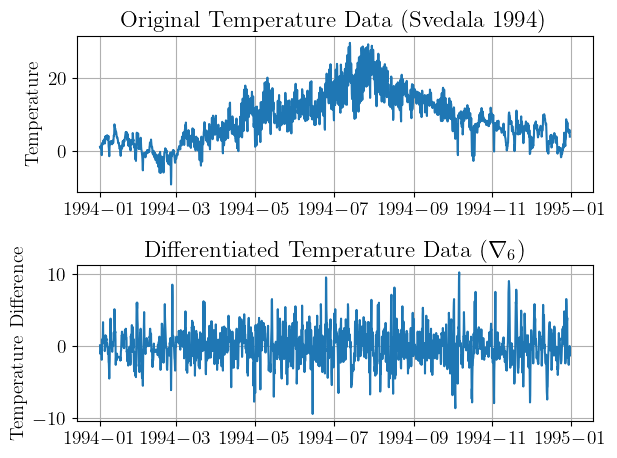

In [31]:
# Load svedala94 data
mat_data = sio.loadmat('../data/svedala94.mat')
y = mat_data['svedala94'].flatten()

ydiff = signal.lfilter([1] + [0]*5 + [-1], [1], y)
ydiff = ydiff[6:]
y = y[6:]

# Create time vector
T = pd.date_range(start='1994-01-01', end='1994-12-31', periods=len(ydiff))

# Does the given time vector take into account the corrupted samples? 


plt.subplot(211)
plt.plot(T, y)
plt.title('Original Temperature Data (Svedala 1994)')
plt.ylabel('Temperature')
plt.grid(True)

plt.subplot(212)
plt.plot(T, ydiff)
plt.title('Differentiated Temperature Data ($\\nabla_6$)')
plt.ylabel('Temperature Difference')
plt.grid(True)

plt.tight_layout()
plt.show()

### 2. Estimate model parameters for different periods

Determine your own model for the first 540 samples. One potential model could be an ARMA(3,6), formed as
$$
\nabla_6 ( 1 + a_1 z^{-1} + a_2 z^{-2} + a_3 z^{-3})y_t = (1 + c_6 z^{-6}) e_t
$$
Did you get a similar model? To allow comparisons, we will now use the above ARMA(3,6) model. Estimate the parameters for this model for a) the winter (say, January to March, i.e., samples 1 to 540), b) summer (say, June to August, i.e., samples 907 to 1458), and c) for the entire year. Compare the different estimated parameters. Do they seem to change? Does the model seem to work reasonably throughout the year?

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.0183(±0.0427)·z⁻¹ + 0.2789(±0.0608)·z⁻² - 0.1734(±0.0434)·z⁻³
C(z) = 1.0 - 0.9076(±0.0216)·z⁻⁶

Polynomial orders: nA = 3    nC = 6
Number of free coefficients: 4
Fit to estimation data (NRMSE): 48.96%
FPE : 0.993  MSE : 0.98
AIC : 1520.875   BIC : 1538.019

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 34.24 < 37.65)
  McLeod-Li test:        False (white if 50.54 < 37.65)
  Monti test:            True (white if 33.08 < 37.65)
  Sign change test:      True (white if 0.46 in [0.46,0.54])
The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


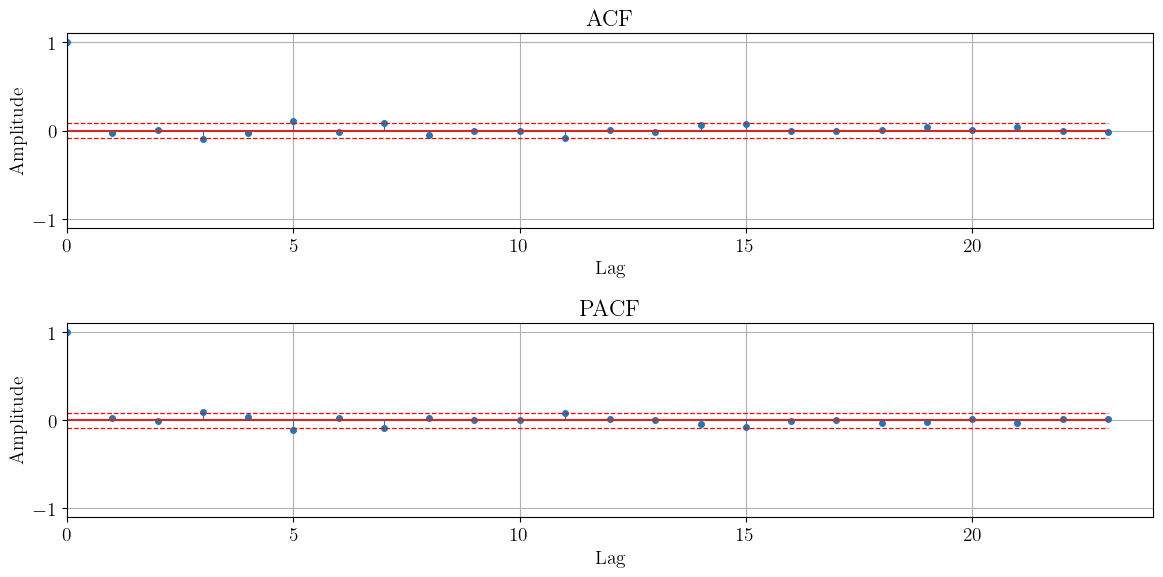

In [12]:
# First, we try some models, to get an idea what would be a reasonable one 
p = 3
q = 6

C_free = [1] + [0]*5 + [1]

mdl = estimateARMA(ydiff[:540], A = p, C = q, C_free=C_free, plot=False)

ehat = mdl.resid[p:]

mdl.summary()
whiteness_test(ehat)
check_if_normal(ehat)

plotACFnPACF(ehat)



## Conclusions

It is difficult to determine the exact model. However, starting with an AR(1), it is obvious that the $c_6$ coefficient is neccesary.  
After adding that one parameter, wee see spikes on 2 and 3 are still in PACF. Increaseing $p$ to 3 gives reasonably good results,  
passing Monti, but D'agostino Pearson indicates non-normal distribution. Hence limited reliability.  

Increasing $p$ to 4 does actually decrease BIC slightly, unlike adding another MA component. To keep the model simple,  
and ARMA(3, 6), with only $c_6$ free is likely a good choice. We could maybe consider the $ARMA(4, 6)$, but this could  
be considered over-modelling.  

See the resulting coefficients of the ARMA(3, 6) for different models below. 

In [13]:
p = 3
q = 6
C_free = [1] + [0]*5 + [1]

mdl_w = estimateARMA(ydiff[:540], A = p, C = q, C_free=C_free, plot=False)
mdl_s = estimateARMA(ydiff[907:1458], A = p, C = q, C_free=C_free, plot=False)

print("Coefficient \t Winter \t Summer")
for i in range(1, len(mdl_w.A)): 
    print(f"a_{i} \t \t {mdl_w.A[i]:.2f} \t \t {mdl_s.A[i]:.2f}")
print(f"c_6 \t \t {mdl_w.C[6]:.2f} \t \t {mdl_s.C[6]:.2f}")

Coefficient 	 Winter 	 Summer
a_1 	 	 -1.02 	 	 -0.83
a_2 	 	 0.28 	 	 0.20
a_3 	 	 -0.17 	 	 -0.20
c_6 	 	 -0.91 	 	 -0.81


### Conclusion

There appears to be a difference

### 3. One-step prediction using winter model

Use the winter model to form a one-step prediction of the temperature for the validation data, here the last 400 samples, i.e., samples 1790 to 2190. To do so, add in the differentiated season in the model before computing the $G(z)$ polynomial to ensure that the prediction is formed in the correct domain. Apply the resulting filter to the *entire* signal. Then, cut out the part of the prediction that forms the validation data (this way you avoid any initialization problems). Plot the ACF of the resulting prediction residual for the validation data and compute its variance.

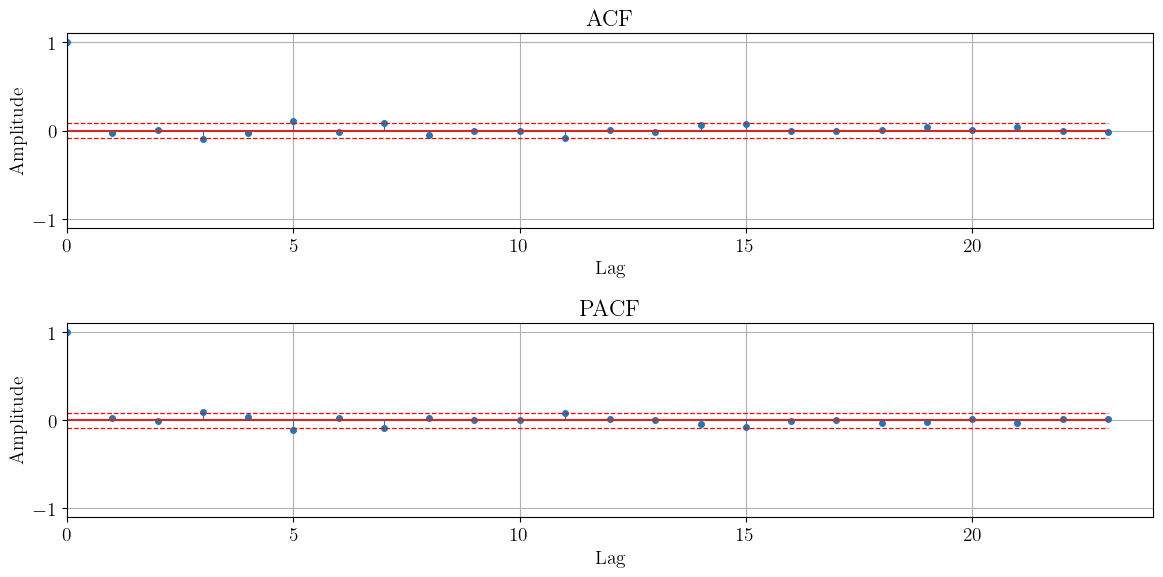

The variance is. 1.1195641706464812


In [14]:
# Add season to A polynomial 
As = np.convolve([1] + [0]*5 + [-1], mdl_w.A)
# Get polynomials for 1 step prediction 
_, G = polydiv(mdl_w.C, As, 1)

# Apply to data 
yhat = signal.lfilter(G, mdl_w.C, y) # I did not save the new y in its own variable, but we are predicting the last samples, it probably does not matter a lot. 

# Isolate validation data 
yhat_val = yhat[1790:2190]
y_val = y[1790:2190]
e_pred = yhat_val - y_val

plotACFnPACF(ehat)
variance = np.var(e_pred, ddof=0)
print(f"The variance is. {variance}")


### 4. Kalman filter estimation throughout the year

Use the Kalman filter to estimate the parameters of the ARMA(3,6) model throughout the year. To do so requires some care. To begin with, do not remove the initial samples when forming $z_t = \nabla_6 y_t = y_t - y_{t-6}$. Clearly, these initial samples will be corrupted, as always, but we will instead remove these later to simplify the alignment of the vectors. Then, form the Kalman filter predict $\hat{z}_{t|t-1}$ using the ARMA structure above using the appropriate `C` vector. As
$$
 \hat{y}_{t|t-1}=  \hat{z}_{t|t-1} + y_{t-6}
$$
you can reconstruct $\hat{y}_{t|t-1}$ using:
```python
zt = C @ x_t1                # \hat{z}_{t|t-1}
yhat[t] = zt + y[t-6]        # \hat{y}_{t|t-1}
```
Next, you can initiate the model at the beginning of the data set using the parameters you have found from the modeling data. To make the plots a bit nicer, we do this also for the states before the predictions:
```python
xt = np.zeros((p0+q0, N))
for k in range(6):
    xt[:, k] = np.concatenate([winterModel.A[1:], [winterModel.C[-1]]])
```
Here, the parameters `p0` and `q0` indicate the number of unknown coefficients in the $A(z)$ and $C(z)$-polynomials, respectively. As this choice of initial states should be fairly accurate, you trust your initial estimates to be reasonably good and can thus select a low initial $R_{1|0}^{x,x}$, for instance using
```python
Rx_t1 = 1e-5 * np.eye(p0+q0)
Re    = 1e-5 * np.eye(p0+q0)
Rw    = 2
```
where we have also selected rather low values for $R_w$ and $R_e$; try using some different values to get a feel for how these choices affect the resulting estimates and if you can improve the quality of the estimates. Note that you can (and maybe should?) have different parameter variances.

Compare the resulting prediction with the result you got above when using the winter model as well as with the naive predictor. As you can see, the winter model is actually rather stable and actually works quite well even for the validation data, even without allowing the parameters to vary. Can you suggest any reasons why this might be?

The variance is 1.1400135627265093


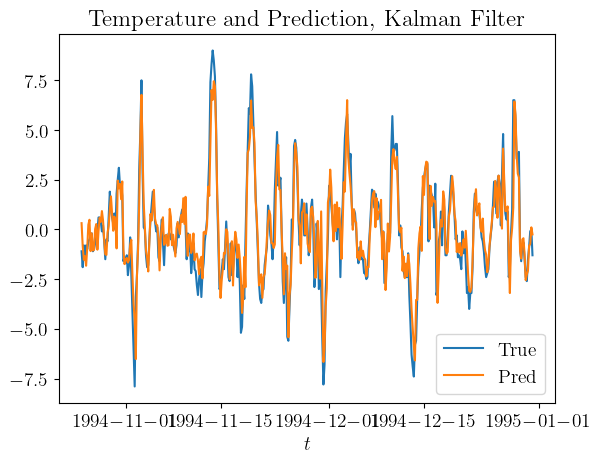

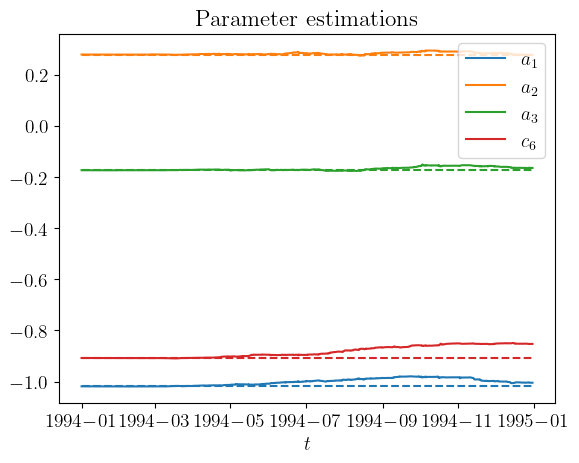

In [102]:
# Reload data with previously removed samples 
y = mat_data['svedala94'].flatten()
z = signal.lfilter([1] + [0]*5 + [-1], [1], y)        # Do we filter here, I believe so given the instructions 

# Number of unknowns in the state vector 
N = y.size
p0 = 3
q0 = 1

# Define covariance for the Kalman filter 
Rx_t1 = 1e-5 * np.eye(p0 + q0)
Re    = 1e-6 * np.eye(p0 + q0)
Rw    = 10

# Initiate data based on our previous model 
xt = np.zeros((p0 + q0, N))
for k in range(6):
    xt[:, k] = np.concatenate([mdl_w.A[1:], [mdl_w.C[-1]]])

# Allocate arrays for results and matrices 
A = np.eye(p0 + q0)
h_et = np.zeros(N)         # Estimated prediction error.   
yhat = np.zeros(N)          # Estimated 1-step prediction.
 
# Here we have an MA(6) component, meaning we can start at index 6 
# Since we make a 1 step prediction, the last prediciton is t_N at t_N-
# However, as we are doing it in the current step, we can iterate to N 
for t in range(6, N):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]               # x_{t|t-1} 
    C = np.array([[-z[t-1], -z[t-2], -z[t-3], h_et[t-6]]])                              # C_{t|t-1}
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw                              # R_{t|t-1}^{y,y}
    Kt = Rx_t1 @ C.T / Ry                            # K_t
    zhat = (C @ x_t1)[0]            # \hat{y}_{t|t-1}.
    zhatv[t] = zhat
    yhat[t] = zhat + y[t - 6]
    h_et[t] = z[t] - zhat               # Prediction error in z 
    xt[:, t] = x_t1 + Kt[:,0] * h_et[t]      # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T                          # R^{x,x}_{t|t}
    Rx_t1 = A @ Rx_t @ A.T + Re                           # R^{x,x}_{t+1|t} 

# Save the validation part to comapre with previous task, 
y_val = y[-400:]
yhat_val = yhat[-400:]
T_val = T[-400:]

pe = yhat_val - y_val
variance = np.var(pe, ddof=0)
print(f"The variance is {variance}")


fig, ax = plt.subplots() 
ax.plot(T_val, z[-400:], label='True')
ax.plot(T_val, zhatv[-400:], label='Pred')
ax.set_xlabel('$t$')
ax.set_title('Temperature and Prediction, Kalman Filter')
ax.legend()


Tse = T[[0, -1]]
xmod = np.block([[mdl_w.A[1:, None], mdl_w.A[1:, None]], [mdl_w.C[-1, None], mdl_w.C[-1, None]]])
fig, ax = plt.subplots() 
labels = ["$a_1$", "$a_2$", "$a_3$", "$c_6$"]
cols = ['C0','C1','C2','C3']
for i in range(4): 
    ax.plot(T, xt[i, 6:], color=cols[i], label=labels[i])
    ax.plot(Tse, xmod[i, :], '--', color=cols[i])
ax.set_xlabel('$t$')
ax.set_title('Parameter estimations')
ax.legend() 





### Conclusions 
We tuned the parameters $R_e$ and $R_w$, to ensure the madel parameter estimates update slower.  
We expect that the model whould have parameters that on a short term stay relatively constant.  
This slightly lowers the variance of the prediction error 


### 5. Multi-step predictions

Proceed to plot the 2-step and 3-step predictions of the temperature data. It is worth noting that the 3-step prediction will need to use the 2-step prediction. Compute the variance of the corresponding prediction residuals.

2-step variance 2.6168608718854784
3-step variance 3.64673031580366


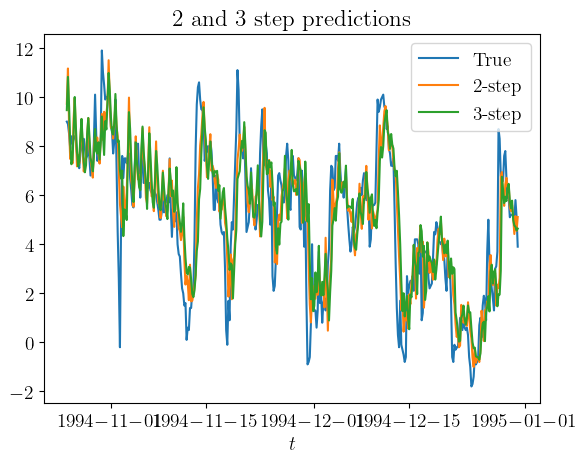

In [107]:
## re-initiate data based on our previous model 
xt = np.zeros((p0 + q0, N))
for k in range(6):
    xt[:, k] = np.concatenate([mdl_w.A[1:], [mdl_w.C[-1]]])

# Allocate arrays for results and matrices 
A = np.eye(p0 + q0)
h_et = np.zeros(N)         # Estimated prediction error.   
yhat2 = np.zeros(N+2)          # Estimated 2-step prediction.
yhat3 = np.zeros(N+3)
 
# Here we have an MA(6) component, meaning we can start at index 6 
# Since we make a 1 step prediction, the last prediciton is t_N at t_N-
# However, as we are doing it in the current step, we can iterate to N 
for t in range(6, N):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]               # x_{t|t-1} 
    C = np.array([[-z[t-1], -z[t-2], -z[t-3], h_et[t-6]]])                              # C_{t|t-1}
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw                              # R_{t|t-1}^{y,y}
    Kt = Rx_t1 @ C.T / Ry                                  # K_t
    zhat = (C @ x_t1)[0]                                   # \hat{y}_{t|t-1}.
    yhat[t] = zhat + y[t - 6]
    h_et[t] = z[t] - zhat                                  # Prediction error in z 
    xt[:, t] = x_t1 + Kt[:,0] * h_et[t]                    # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T                         # R^{x,x}_{t|t}
    Rx_t1 = A @ Rx_t @ A.T + Re                            # R^{x,x}_{t+1|t}

    # NOTE: As before, since A = I, A^k is also I for all k
    # in other cases, we would need to include that step!!! 

    # 1 step prediction 
    C1 = np.array([[-z[t], -z[t-1], -z[t-2], h_et[t-5]]])  
    z1 = (C1 @ xt[:, t])[0]

    # 2 step prediction 
    C2 = np.array([[-z1, -z[t], -z[t-1], h_et[t-4]]])
    z2 = (C2 @ xt[:, t])[0]
    yhat2[t+2] = z2 + y[t-4]

    # 3 step prediction 
    C3 = np.array([[-z2, -z1, -z[t], h_et[t-3]]])
    z3 = (C3 @ xt[:, t])[0]
    yhat3[t+3] = z3 + y[t-3]

# Again, select the correct samples for the validation data 
yhat2_val = yhat2[1790:2190]
yhat3_val = yhat3[1790:2190]

print(f"2-step variance {np.var(yhat2_val - y_val, ddof=0)}")
print(f"3-step variance {np.var(yhat3_val - y_val, ddof=0)}")

fig, ax = plt.subplots()
ax.plot(T_val, y_val, label='True')
ax.plot(T_val, yhat2_val, label='2-step')
ax.plot(T_val, yhat3_val, label='3-step')
ax.set_xlabel('$t$')
ax.set_title('2 and 3 step predictions')
ax.legend()

### Discussion

**Be prepared to show your parameter estimates and predictions when discussing with the examiner at the computer exercise!**

## 2.6 (optional) Examine the project data

Using the model for the input signal you developed in the second computer exercise, form a one-step prediction of this signal using a Kalman filter. Select the state covariances using the variance of the estimated prediction residual and the standard deviation of the parameter estimates you obtained in the second computer exercise. Initiate your parameters with the values you obtain in the second exercise.

Start the filtering at the beginning of the entire data set, to avoid any initialization and convergence effects, and then extract the predictions for the validation data. Is the prediction residual white? Compute the variance of the prediction residual. Plot the estimated parameters. Are these similar to the ones you had with the fixed model? Are some parameters very small in comparison to their standard deviations? Are they significant? Can you remove some parameters without increasing the variance of the prediction residual more than marginally? Do you get better estimates if you fix some of the parameters so that these are not allowed to vary, instead using the parameter value you had from the second exercise?

Form a $k$-step prediction of the input using the Kalman filter. Recall that you need to update the `C_t` vector at each step. How should you handle the future noise estimates? Examine the ACF of the prediction residual as well as its variance. Do you get a lower variance than you had for your fixed-parameter model?

*Hint:* You will typically perform these task as part of your project, so the time you spend on this now will be time saved later on...

## 3. Kalman Filter Outline

Below is an example of a Kalman filter implementation for reference.

In [ ]:
# Example of Kalman filter

# Simulate N samples of a process to test your code.
y = ?                       # Simulated data          

# Define the state space equations. 
A   = ?
Re  = ?                     # State covariance matrix
Rw  = ?                     # Observation variance

# Set some initial values
Rx_t1 = ? * np.eye(?)       # R_{1|0}^{x,x}
h_et  = np.zeros(?)         # Estimated prediction error.
xt    = np.zeros((?, ?))    # Estimated states. 
yhat1 = np.zeros(?)         # Estimated 1-step prediction.
yhat2 = np.zeros(?)         # Estimated 2-step prediction.

# Where should the loop start and stop?
for t in range(?, ?):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]               # x_{t|t-1} 
    Ct = ?                              # C_{t|t-1}
    
    # Update the parameter estimates.
    Ry = ?                              # R_{t|t-1}^{y,y}
    Kt = ?                              # K_t
    yhat = Ct @ x_t1                    # \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat               # Prediction error,
    xt[:, t] = x_t1 + Kt * h_et[t]      # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = ?                           # R^{x,x}_{t|t}
    Rx_t1 = ?                           # R^{x,x}_{t+1|t} 

    # Form \hat{y}_{t+1|t}.
    Ct1 = ?                             # C_{t+1|t}
    yhat1[t+1] = Ct1 @ xt[:, t]         # \hat{y}_{t+1|t} 

    # Form \hat{y}_{t+2|t}.
    Ct2 = ?                             # C_{t+2|t}
    yhat2[t+2] = Ct2 @ xt[:, t]         # \hat{y}_{t+2|t}